In [1]:
!pip install vaderSentiment

     |████████████████████████████████| 125 kB 2.1 MB/s            


In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from wordcloud import WordCloud

import spacy
# !python -m spacy download en_core_web_lg
nlp = spacy.load('en_core_web_lg')
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer


from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, plot_confusion_matrix, accuracy_score
from xgboost import XGBClassifier

# Data Exploration

Read not fake news examples:

In [3]:
true_df = pd.read_csv("../input/fake-and-real-news-dataset/True.csv")
true_df

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"
...,...,...,...,...
21412,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017"
21413,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017"
21414,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017"
21415,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017"


Read the fake news examples:

In [4]:
fake_df = pd.read_csv("../input/fake-and-real-news-dataset/Fake.csv")
fake_df

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"
...,...,...,...,...
23476,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016"
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016"
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016"
23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016"


Concat the real and fake news into single dataset:

In [5]:
true_df["fake"] = False
fake_df["fake"] = True
df = pd.concat([true_df, fake_df])
df

,title,text,subject,date,fake
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",False
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",False
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",False
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",False
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",False
...,...,...,...,...,...
23476,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016",True
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016",True
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016",True
23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016",True


The dataset consists of the following fields:
1. **title** - the title of the article
2. **text** - the text of the article
3. **subject** - the subject of the article
4. **date** - the date at which the article was posted

# Convert Datetime Columns

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44898 entries, 0 to 23480
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   fake     44898 non-null  bool  
dtypes: bool(1), object(4)
memory usage: 1.8+ MB


Convert datatime 'object' coulumns to 'datetime', removing values that are invalid dates:

In [7]:
df.date = pd.to_datetime(df["date"], errors="coerce")
df

,title,text,subject,date,fake
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,2017-12-31,False
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,2017-12-29,False
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,2017-12-31,False
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,2017-12-30,False
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,2017-12-29,False
...,...,...,...,...,...
23476,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,2016-01-16,True
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,2016-01-16,True
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,2016-01-15,True
23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,2016-01-14,True


Remove all rows having empty 'date' value (this includes both cells we emptied becuase format was incorrect and actually empty cells):

In [8]:
df = df.dropna()

# Handle Missing Values

We have no missing values:

In [9]:
df.describe()

,title,text,subject,date,fake
count,44888,44888,44888,44888,44888
unique,38723,38640,8,1010,2
top,Factbox: Trump fills top jobs for his administ...,,politicsNews,2017-12-20 00:00:00,True
freq,14,627,11272,197,23471
first,NaN,NaN,NaN,2015-03-31 00:00:00,NaN
last,NaN,NaN,NaN,2018-02-19 00:00:00,NaN


# Remove Duplicates

We have quite a lot of duplicates. Let's drop them:

In [10]:
print(f"Number of duplicates: {df.duplicated().sum()}")

Number of duplicates: 209


In [11]:
df = df.drop_duplicates()
df

,title,text,subject,date,fake
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,2017-12-31,False
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,2017-12-29,False
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,2017-12-31,False
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,2017-12-30,False
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,2017-12-29,False
...,...,...,...,...,...
23476,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,2016-01-16,True
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,2016-01-16,True
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,2016-01-15,True
23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,2016-01-14,True


# Inspect Columns

## Subject

In [12]:
df.subject.unique()

array(['politicsNews', 'worldnews', 'News', 'politics', 'Government News',
       'left-news', 'US_News', 'Middle-east'], dtype=object)

Text(0.5, 1.0, 'News distribution by subject')

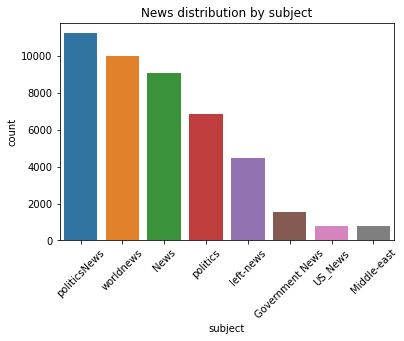

In [13]:
plot = sns.countplot(x="subject", data=df, order=df.subject.value_counts().index)
plot.set_xticklabels(plot.get_xticklabels(), rotation=45)
plot.set_title("News distribution by subject")

In [14]:
(df.subject.value_counts(normalize=True) * 100)

politicsNews       25.112469
worldnews          22.361736
News               20.255601
politics           15.293538
left-news           9.973366
Government News     3.509479
US_News             1.752501
Middle-east         1.741310
Name: subject, dtype: float64

Viewing how many fake and real news belong to each subject we come to the following conclusions:
1. All news in **politicsNews** and **worldnews** are NOT FAKE
2. All news in other labels are indeed FAKE

So technically by using only the **subject** column we can classify all news in this dataset correctly.

Text(0.5, 1.0, 'News distribution by subject')

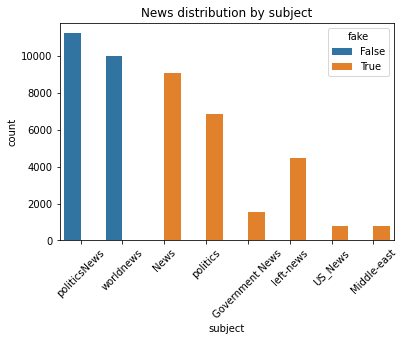

In [15]:
plot = sns.countplot(x="subject", data=df, hue="fake")
plot.set_xticklabels(plot.get_xticklabels(), rotation=45)
plot.set_title("News distribution by subject")

This may suggest that fake news may have certain subjects which are attractive or controversial (such as "left-news" or "Middle-east). Most likely though, it may suggest that the dataset includes examples only for specificly generated fake news which may not represent actual fake news in reality.

## Date

Text(0.5, 1.0, 'Fake vs. Real News Overtime')

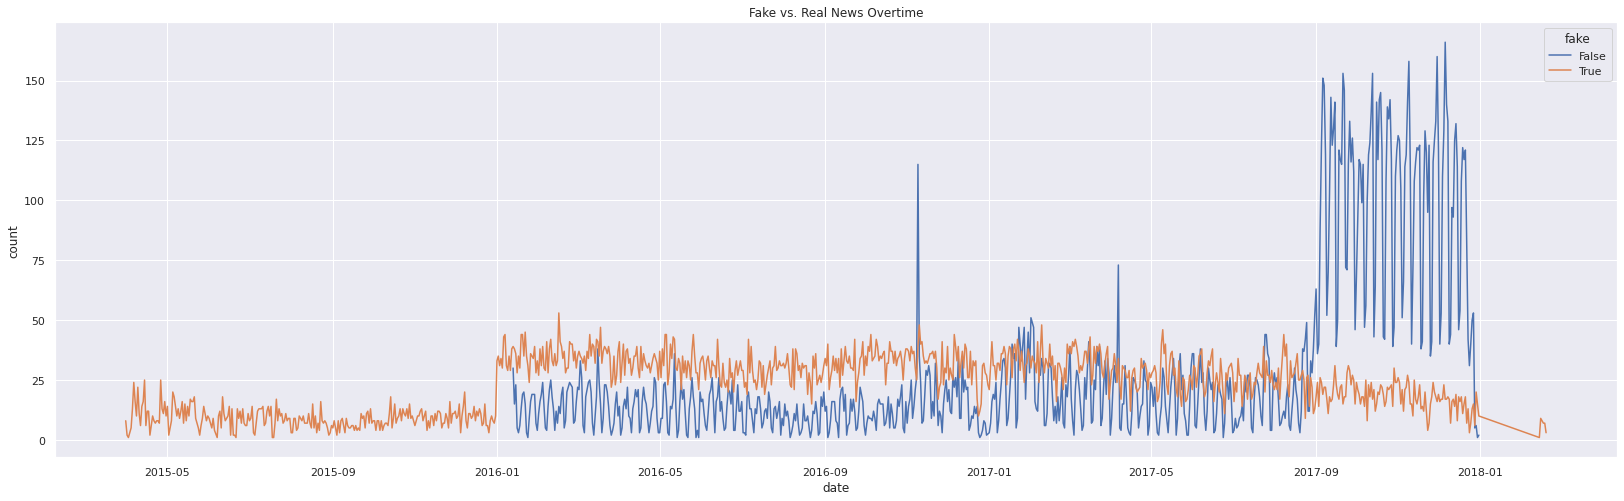

In [16]:
grouped = df.groupby(by=["date", "fake"]).count()
grouped.rename(columns={"title": "count"}, inplace=True)
grouped.drop(columns=["text", "subject"], inplace=True)
sns.set(rc={'figure.figsize':(28,8)})
plot = sns.lineplot(data=grouped, x="date", y="count", hue="fake")
plot.set_title("Fake vs. Real News Overtime")

## Title

### Inspect Lengths

In [17]:
def get_length_stats(field_name):
    new_field = field_name + "_length"
    df[new_field] = df[field_name].map(lambda x: len(x))
    stats = df[["fake", new_field]].groupby("fake").mean()
    stats.rename(columns={field_name: "avg"}, inplace=True)
    stats["min"] = df[["fake", new_field]].groupby("fake").min()[new_field]
    stats["max"] = df[["fake", new_field]].groupby("fake").max()[new_field]
    return stats

In [18]:
stats = get_length_stats("title")
stats

,title_length,min,max
fake,,,
False,64.658291,26,133
True,94.199676,15,286


Seems like fake news tend to have **longer** titles than real news. One possible reason is the need to attract readers fast, presenting the action items of the news.

Text(0.5, 1.0, 'Titles Length Counts')

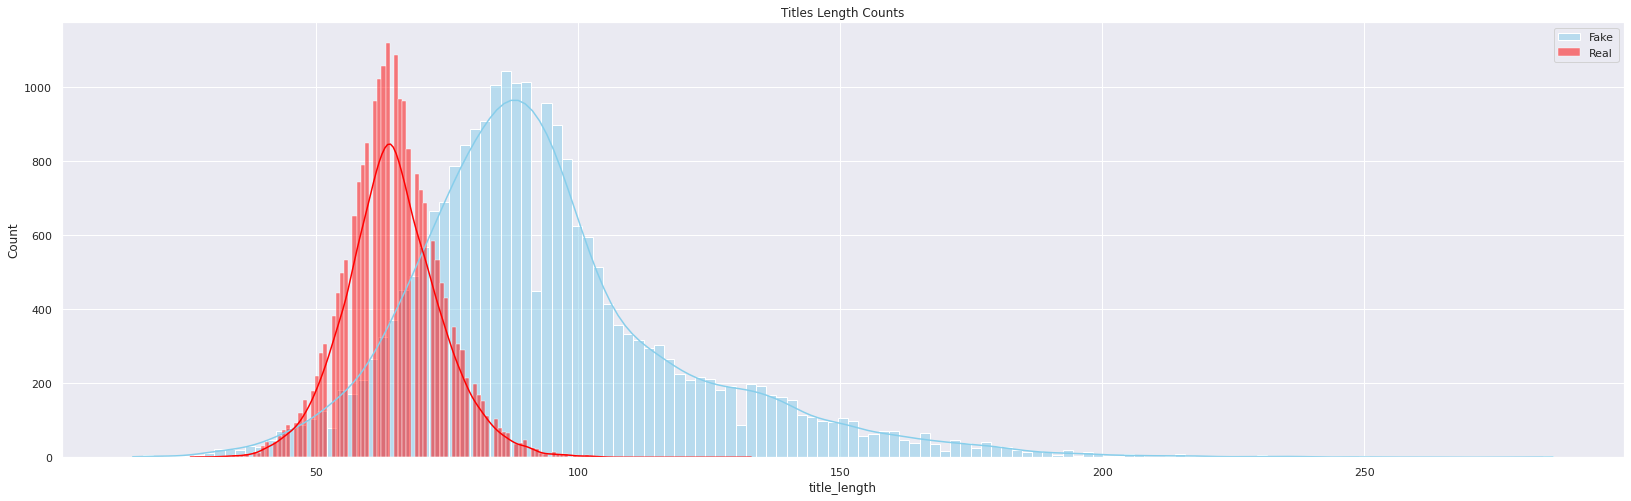

In [19]:
sns.histplot(data=df[df["fake"] == True], x="title_length", color="skyblue", label="Fake", kde=True)
sns.histplot(data=df[df["fake"] == False], x="title_length", color="red", label="Real", kde=True)
plt.legend() 
plt.title("Titles Length Counts")

### Lemmatization

In [20]:
def lemmatize(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc])

In [21]:
df["title_lemmatized"] = df["title"].apply(lemmatize)
df

,title,text,subject,date,fake,title_length,title_lemmatized
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,2017-12-31,False,64,"as U.S. budget fight loom , Republicans flip t..."
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,2017-12-29,False,64,U.S. military to accept transgender recruit on...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,2017-12-31,False,60,senior U.S. republican senator : ' let Mr. Mue...
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,2017-12-30,False,59,FBI Russia probe help by australian diplomat t...
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,2017-12-29,False,69,Trump want Postal Service to charge ' much mor...
...,...,...,...,...,...,...,...
23476,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,2016-01-16,True,61,mcpain : John McCain Furious that Iran treat U...
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,2016-01-16,True,81,justice ? Yahoo settle e - mail Privacy Class ...
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,2016-01-15,True,85,Sunnistan : US and Allied ' Safe Zone ' plan t...
23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,2016-01-14,True,67,how to blow $ 700 million : Al Jazeera America...


### Word Clouds Visualizations

In [22]:
def display_word_cloud(field_name, fake, title):
    words = df[df['fake'] == fake][field_name]
    cloud = WordCloud(width=2000, height=1000, collocations=False, background_color="white", colormap="plasma").generate(" ".join(words))
    plt.axis('off')
    plt.title(title,fontsize=40)
    plt.imshow(cloud)

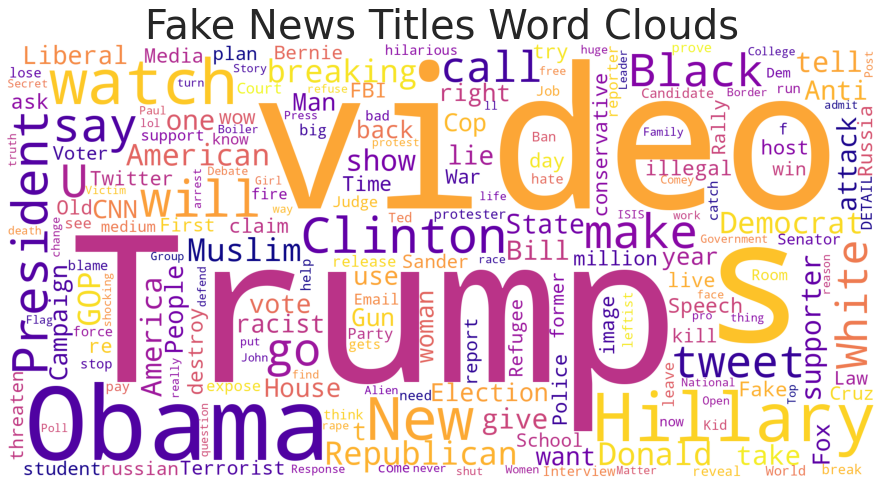

In [23]:
display_word_cloud("title_lemmatized", True, "Fake News Titles Word Clouds")

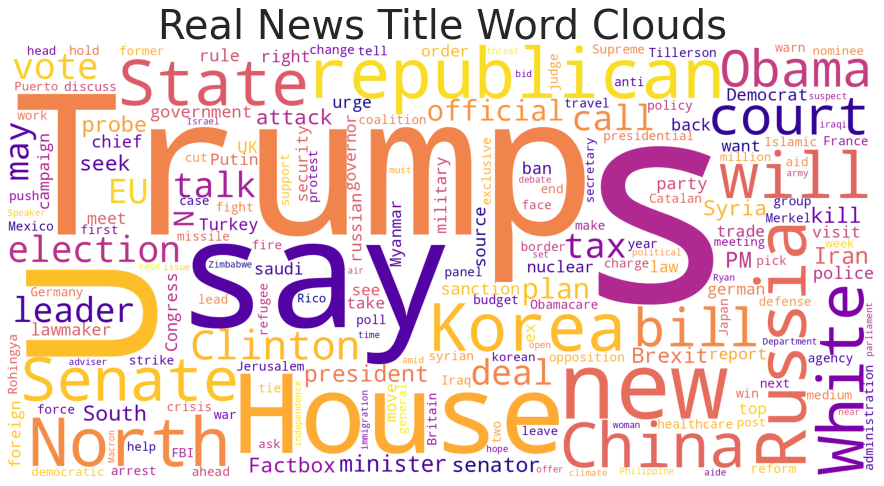

In [24]:
display_word_cloud("title_lemmatized", False, "Real News Title Word Clouds")

## Text

### Inspect Lengths

In [25]:
stats = get_length_stats("text")
stats

,text_length,min,max
fake,,,
False,2378.042337,1,29781
True,2548.582623,1,51794


Text(0.5, 1.0, 'Texts Length Counts')

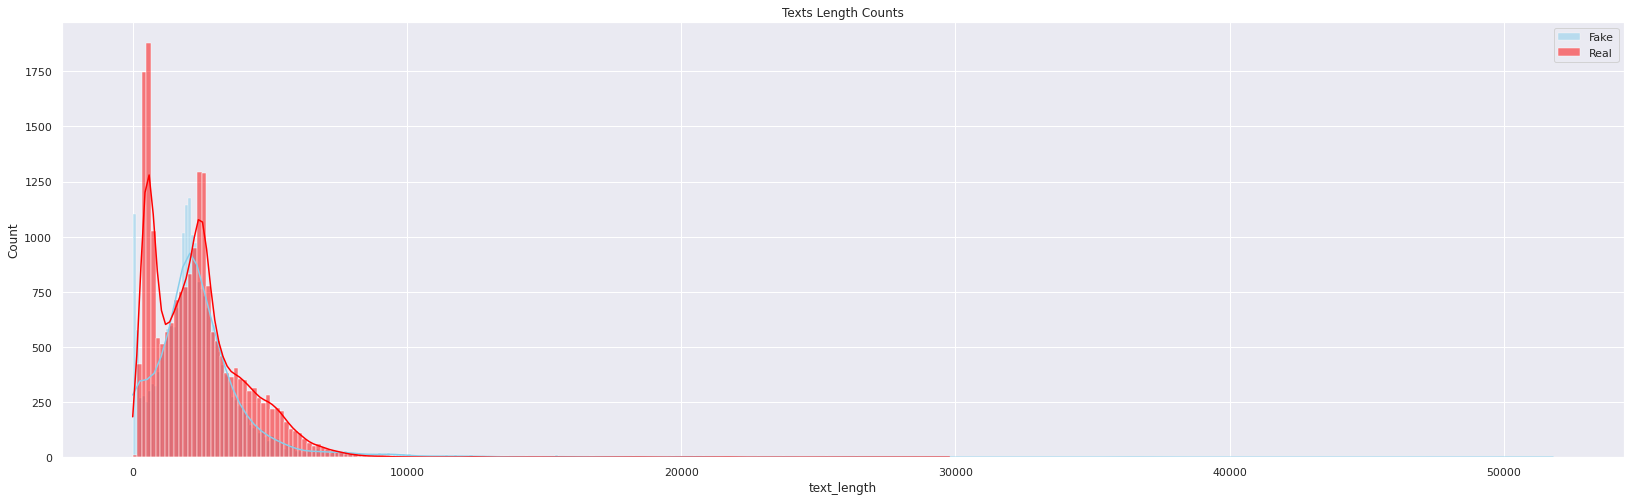

In [26]:
sns.histplot(data=df[df["fake"] == True], x="text_length", color="skyblue", label="Fake", kde=True)
sns.histplot(data=df[df["fake"] == False], x="text_length", color="red", label="Real", kde=True)
plt.legend() 
plt.title("Texts Length Counts")

### Lemmatization

In [27]:
df["text_lemmatized"] = df["text"].apply(lemmatize)
df

,title,text,subject,date,fake,title_length,title_lemmatized,text_length,text_lemmatized
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,2017-12-31,False,64,"as U.S. budget fight loom , Republicans flip t...",4659,WASHINGTON ( Reuters ) - the head of a conserv...
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,2017-12-29,False,64,U.S. military to accept transgender recruit on...,4077,WASHINGTON ( Reuters ) - transgender people wi...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,2017-12-31,False,60,senior U.S. republican senator : ' let Mr. Mue...,2789,WASHINGTON ( Reuters ) - the special counsel i...
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,2017-12-30,False,59,FBI Russia probe help by australian diplomat t...,2461,WASHINGTON ( Reuters ) - trump campaign advise...
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,2017-12-29,False,69,Trump want Postal Service to charge ' much mor...,5204,SEATTLE / WASHINGTON ( Reuters ) - President D...
...,...,...,...,...,...,...,...,...,...
23476,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,2016-01-16,True,61,mcpain : John McCain Furious that Iran treat U...,3237,21st Century Wire say as 21wire report early t...
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,2016-01-16,True,81,justice ? Yahoo settle e - mail Privacy Class ...,1684,21st Century Wire say it s a familiar theme . ...
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,2016-01-15,True,85,Sunnistan : US and Allied ' Safe Zone ' plan t...,25065,Patrick Henningsen 21st Century WireRemember...
23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,2016-01-14,True,67,how to blow $ 700 million : Al Jazeera America...,2685,21st Century Wire say Al Jazeera America will ...


### Word Clouds Visualizations

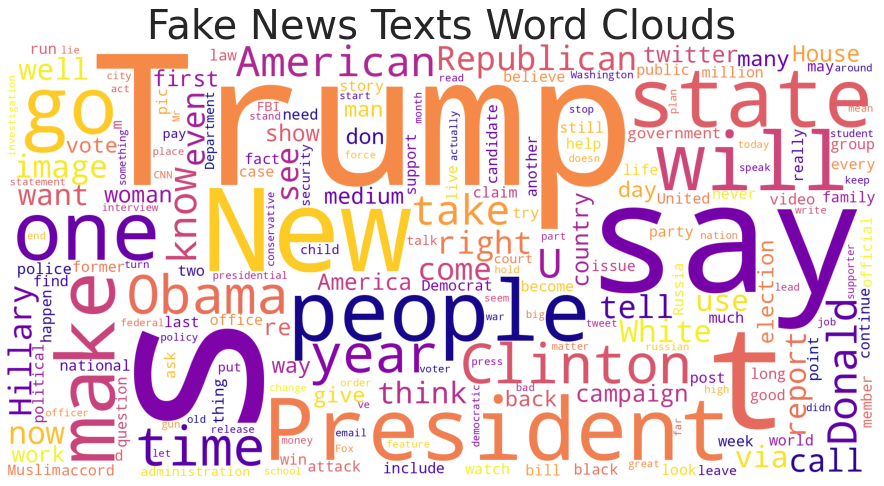

In [28]:
display_word_cloud("text_lemmatized", True, "Fake News Texts Word Clouds")

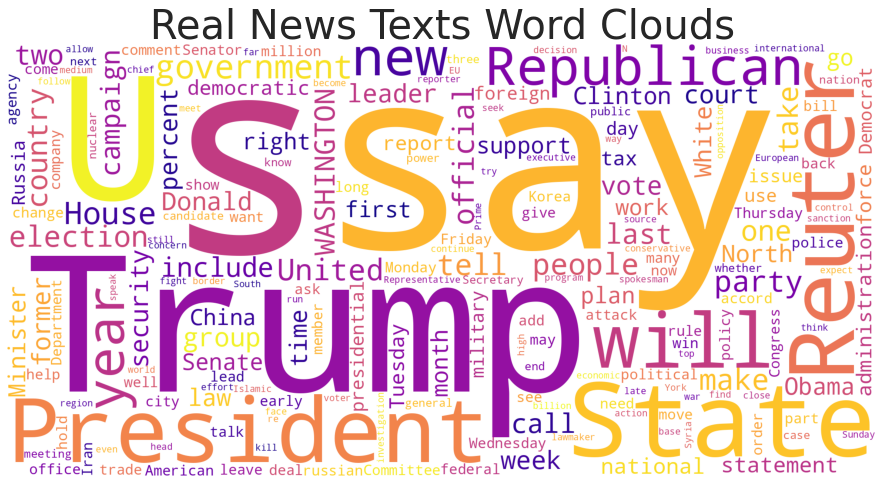

In [29]:
display_word_cloud("text_lemmatized", False, "Real News Texts Word Clouds")

## Fake/Real News

Text(0.5, 1.0, 'News distribution by fake/true')

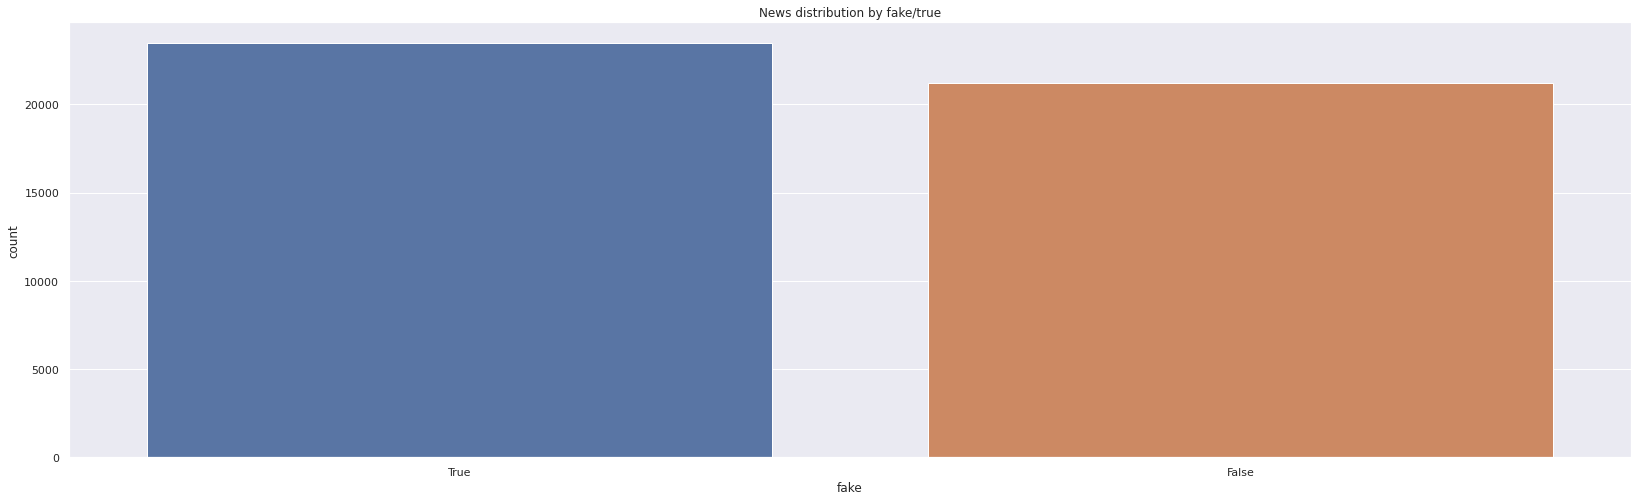

In [30]:
sns.countplot(x="fake", data=df, order=df.fake.value_counts().index).set_title("News distribution by fake/true")

In [31]:
(df.fake.value_counts(normalize=True) * 100)

True     52.525795
False    47.474205
Name: fake, dtype: float64

# Sentiment Analysis

## By Title

In [32]:
analyzer = SentimentIntensityAnalyzer()
df["title_sentiment_score"] = df.title.apply(analyzer.polarity_scores)

In [33]:
def extract_coumpound(score):
    return dict(score)["compound"]

Fake news titles seem to be slightly more negative than real news:

In [34]:
df["title_sentiment_score"] = df["title_sentiment_score"].apply(extract_coumpound)

print(f'Mean sentiment score of FAKE news titles is: {df["title_sentiment_score"][df["fake"] == True].mean()}')
print(f'Mean sentiment score of REAL news titles is: {df["title_sentiment_score"][df["fake"] == False].mean()}')

Mean sentiment score of FAKE news titles is: -0.15979783961138708
Mean sentiment score of REAL news titles is: -0.06793538729904333


## By Text

The texts of the fake vs. the real news seem to be quite neutral (fake news are slightly more negative, while real news are considered positive, but generaly the difference is insignificant).

In [35]:
df["text_sentiment_score"] = df.text.apply(analyzer.polarity_scores)
df["text_sentiment_score"] = df["text_sentiment_score"].apply(extract_coumpound)

print(f'Mean sentiment score of FAKE news texts is: {df["text_sentiment_score"][df["fake"] == True].mean()}')
print(f'Mean sentiment score of REAL news texts is: {df["text_sentiment_score"][df["fake"] == False].mean()}')

Mean sentiment score of FAKE news texts is: -0.06972951678881904
Mean sentiment score of REAL news texts is: 0.07161908915185618


# Convert Binary To Integer

In [36]:
df["fake"] = df["fake"].astype(int)
df

,title,text,subject,date,fake,title_length,title_lemmatized,text_length,text_lemmatized,title_sentiment_score,text_sentiment_score
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,2017-12-31,0,64,"as U.S. budget fight loom , Republicans flip t...",4659,WASHINGTON ( Reuters ) - the head of a conserv...,-0.4939,0.9847
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,2017-12-29,0,64,U.S. military to accept transgender recruit on...,4077,WASHINGTON ( Reuters ) - transgender people wi...,0.3818,-0.5363
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,2017-12-31,0,60,senior U.S. republican senator : ' let Mr. Mue...,2789,WASHINGTON ( Reuters ) - the special counsel i...,0.0000,-0.6808
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,2017-12-30,0,59,FBI Russia probe help by australian diplomat t...,2461,WASHINGTON ( Reuters ) - trump campaign advise...,0.0000,-0.2201
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,2017-12-29,0,69,Trump want Postal Service to charge ' much mor...,5204,SEATTLE / WASHINGTON ( Reuters ) - President D...,0.2449,0.6683
...,...,...,...,...,...,...,...,...,...,...,...
23476,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,2016-01-16,1,61,mcpain : John McCain Furious that Iran treat U...,3237,21st Century Wire say as 21wire report early t...,-0.3818,0.9239
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,2016-01-16,1,81,justice ? Yahoo settle e - mail Privacy Class ...,1684,21st Century Wire say it s a familiar theme . ...,0.6289,0.9529
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,2016-01-15,1,85,Sunnistan : US and Allied ' Safe Zone ' plan t...,25065,Patrick Henningsen 21st Century WireRemember...,0.0000,-0.9992
23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,2016-01-14,1,67,how to blow $ 700 million : Al Jazeera America...,2685,21st Century Wire say Al Jazeera America will ...,0.0000,-0.0409


# Prediction Model

## By title

In [37]:
X_train, X_test, y_train, y_test = train_test_split(df["title_lemmatized"], df["fake"], test_size=0.2, random_state=42, shuffle=True, stratify=df["fake"])

In [38]:
tfidf = TfidfVectorizer(min_df=3,  max_features=None, stop_words='english')

pipeline = Pipeline([
    ("tfidf", tfidf),
    ("clf", XGBClassifier(random_state=42))
])

pipeline.fit(X_train, y_train)

[15:41:27] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('tfidf', TfidfVectorizer(min_df=3, stop_words='english')),
                ('clf',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, enable_categorical=False,
                               gamma=0, gpu_id=-1, importance_type=None,
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=4, num_parallel_tree=1, predictor='auto',
                               random_state=42, reg_alpha=0, reg_lambda=1,
                               scale_pos_weight=1, subsample=1,
                               tree_method='exact', validate_parameters=1,
                               

In [39]:
def evaluate_model(model, X_test, y_test):
    predictions = model.predict(X_test)
    print(f"Accuracy: {accuracy_score(y_test, predictions)}")
    print(classification_report(y_test, predictions))
    plot_confusion_matrix(model, X_test, y_test)

Accuracy: 0.9115935541629364
              precision    recall  f1-score   support

           0       0.87      0.96      0.91      4242
           1       0.96      0.87      0.91      4694

    accuracy                           0.91      8936
   macro avg       0.91      0.91      0.91      8936
weighted avg       0.92      0.91      0.91      8936



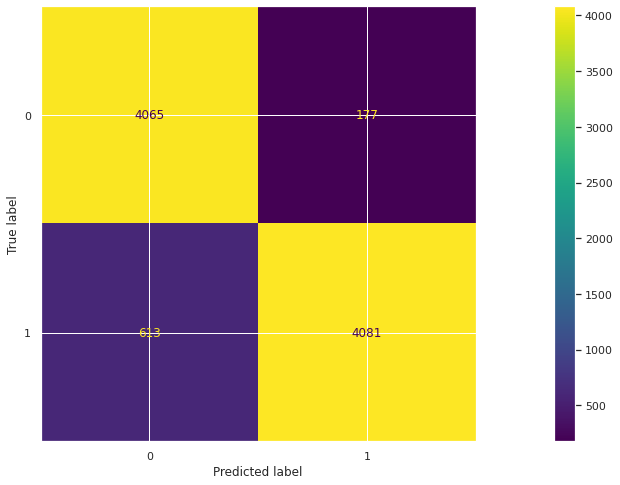

In [40]:
evaluate_model(pipeline, X_test, y_test)

## By text

In [41]:
X_train, X_test, y_train, y_test = train_test_split(df["text_lemmatized"], df["fake"], test_size=0.2, random_state=42, shuffle=True, stratify=df["fake"])

pipeline = Pipeline([
    ("tfidf", tfidf),
    ("clf", XGBClassifier(random_state=42))
])

pipeline.fit(X_train, y_train)

[15:41:52] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('tfidf', TfidfVectorizer(min_df=3, stop_words='english')),
                ('clf',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, enable_categorical=False,
                               gamma=0, gpu_id=-1, importance_type=None,
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=4, num_parallel_tree=1, predictor='auto',
                               random_state=42, reg_alpha=0, reg_lambda=1,
                               scale_pos_weight=1, subsample=1,
                               tree_method='exact', validate_parameters=1,
                               

Accuracy: 0.9984333034914951
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4242
           1       1.00      1.00      1.00      4694

    accuracy                           1.00      8936
   macro avg       1.00      1.00      1.00      8936
weighted avg       1.00      1.00      1.00      8936



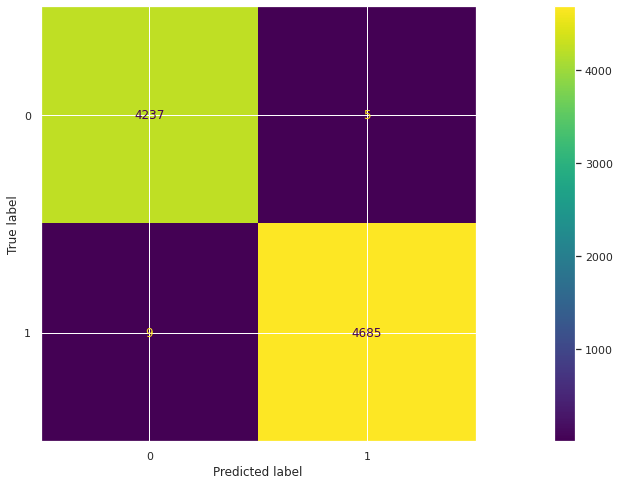

In [42]:
evaluate_model(pipeline, X_test, y_test)